<a href="https://www.kaggle.com/code/ahmed3okka/pg-s3-e25-modeling-rf-submission?scriptVersionId=150597157" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from tqdm.auto import tqdm
import xgboost as xgb

# Set XGBoost hyperparameters
n_estimators = 600
max_depth = 6

In [84]:
# Read the CSV files
df = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")
submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

df.head()  # Display the first few rows of the combined DataFrame

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [85]:
df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [86]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing #'] = df.isna().sum()
    sum['missing %'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum
summary(df)

,dtypes,missing #,missing %,uniques,count
allelectrons_Total,float64,0,0.0,325,10407
density_Total,float64,0,0.0,1099,10407
allelectrons_Average,float64,0,0.0,629,10407
val_e_Average,float64,0,0.0,205,10407
atomicweight_Average,float64,0,0.0,849,10407
ionenergy_Average,float64,0,0.0,898,10407
el_neg_chi_Average,float64,0,0.0,745,10407
R_vdw_element_Average,float64,0,0.0,737,10407
R_cov_element_Average,float64,0,0.0,698,10407
zaratio_Average,float64,0,0.0,815,10407


In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.0,0.493349,0.063080,0.0,0.476196,0.488550,0.496070,0.825990


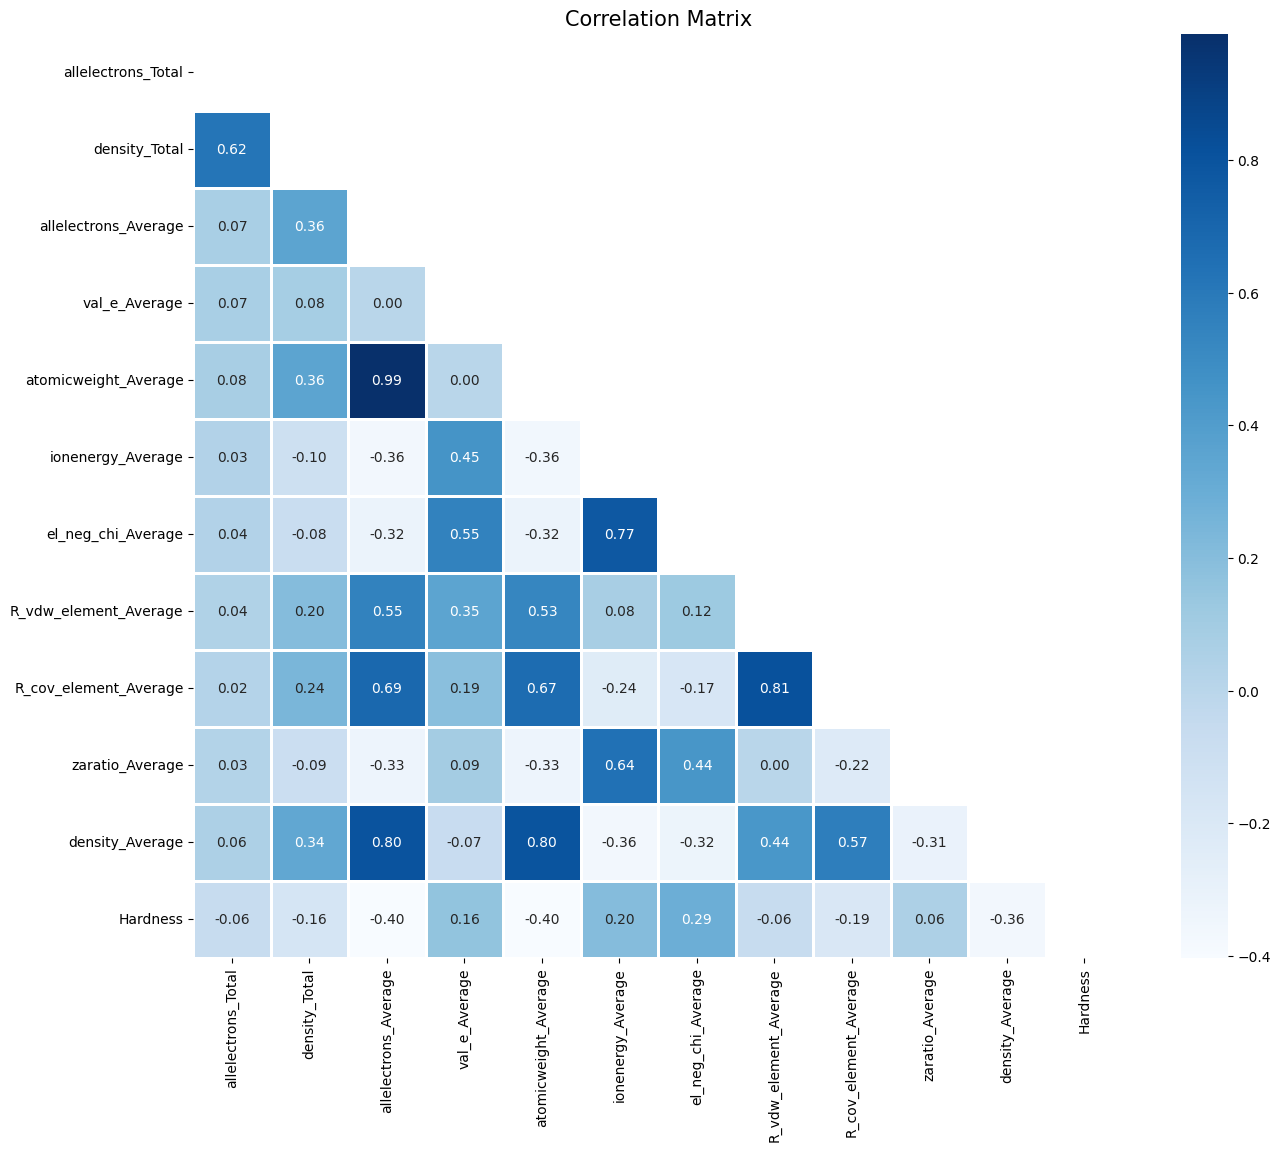

In [88]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues',  fmt='.2f', linewidths=2 )

plt.title('Correlation Matrix', fontsize=15)
plt.show()

Notice that there are strong relatio between to valriables. we may remove one of them. 

In [89]:
df_train , df_val = train_test_split(df, test_size=0.2, random_state=1)


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.Hardness.values
y_val = df_val.Hardness.values

del df_train['Hardness']
del df_val['Hardness']

In [99]:
# define standard scaler
scaler = StandardScaler()
# transform data
df_train = scaler.fit_transform(df_train)
df_val = scaler.fit_transform(df_val)
df_test = scaler.fit_transform(test_df)

In [92]:
max_depth = [10, 15, 20, 25]
n_estimator = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
scores =[]
for m in max_depth:
    for n in n_estimator:
        rf = RandomForestRegressor(n_estimators=n,max_depth=m,random_state=1,n_jobs=-1)
        rf.fit(df_train, y_train)
        y_pred_rf = rf.predict(df_val)
        scores.append((m,n,metrics.median_absolute_error(y_val, y_pred_rf)))

In [93]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimator','median_AE'])
df_scores.round(4).sort_values(by='median_AE')

,max_depth,n_estimator,median_AE
48,20,90,0.6750
68,25,90,0.6753
29,15,100,0.6754
31,15,120,0.6759
49,20,100,0.6771
...,...,...,...
62,25,30,0.7000
14,10,150,0.7043
13,10,140,0.7060
40,20,10,0.7193


In [94]:
scores_pivot = df_scores.pivot(index='max_depth', columns=['n_estimator'],values=['median_AE'])
scores_pivot.round(4)

median_AE                                                          \
n_estimator       10      20      30      40      50      60      70      80    
max_depth                                                                       
10             0.6774  0.6940  0.6982  0.6933  0.6993  0.6957  0.6966  0.6935   
15             0.6986  0.6922  0.6907  0.6793  0.6902  0.6898  0.6883  0.6804   
20             0.7193  0.6964  0.6774  0.6824  0.6883  0.6813  0.6856  0.6771   
25             0.7300  0.6979  0.7000  0.6850  0.6913  0.6875  0.6837  0.6838   

                                                                             \
n_estimator     90      100     110     120     130     140     150     160   
max_depth                                                                     
10           0.6861  0.6954  0.6908  0.6994  0.6982  0.7060  0.7043  0.6982   
15           0.6783  0.6754  0.6777  0.6759  0.6803  0.6836  0.6873  0.6798   
20           0.6750  0.6771  0.6808  0.6820  0.6860  0.6929  0.6946  0.6922   
25           0.6753  0.6792  0.6834  0.6837  0.6900  0.6891  0.6956  0.6890   

                                             
n_estimator     170     180     190     200  
max_depth                                    
10           0.6983  0.6984  0.6991  0.6934  
15           0.6778  0.6855  0.6800  0.6799  
20           0.6926  0.6944  0.6918  0.6958  
25           0.6920  0.6961  0.6950  0.6905

<Axes: xlabel='None-n_estimator', ylabel='max_depth'>

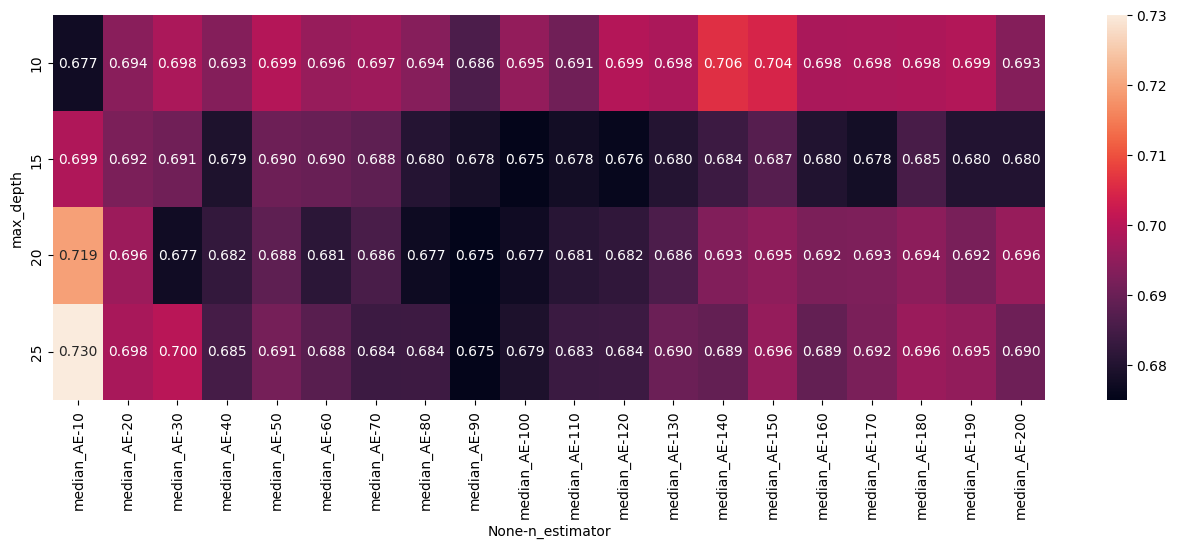

In [95]:
plt.figure(figsize = (16,5))
sns.heatmap(scores_pivot,annot=True,fmt='.3f')

In [97]:
rf = RandomForestRegressor(n_estimators=30,max_depth=15,random_state=1,n_jobs=-1)
rf.fit(df_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=30, n_jobs=-1, random_state=1)

In [100]:
xgboost = xgb.XGBRegressor(random_state = 42, objective = 'reg:absoluteerror')
xgboost.fit(df_train, y_train)
y_pred = rf.predict(df_val)
metrics.median_absolute_error(y_val, y_pred)

0.6907438411886972

In [ ]:
y_test = rf.predict(test_df)
# Update the 'smoking' column in the submission DataFrame with predicted values
submission['Hardness'] = y_test

# Save the submission file without index to a CSV
submission.to_csv('submission.csv', index=False)